# Results Visualization

Tools to visualize training metrics and compare models.

Features:
- Training curves visualization (loss, rotation error, translation error)
- RGB vs RGBD model comparison
- Results summary tables

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch

# Add project root to path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load Training History

In [2]:
def load_history(model_name, object_name, pipeline_type='rgbd'):
    """
    Load training history from JSON file.
    
    Args:
        model_name: Model name (e.g., 'residual_learning' for RGBD, or 'rgb' for RGB)
        object_name: Object name (e.g., 'ape')
        pipeline_type: 'rgb' or 'rgbd'
    
    Returns:
        Normalized history dict with: train_loss, val_loss, rot_err, trans_err
        All translation errors are returned in cm.
    """
    if pipeline_type == 'rgb':
        base_dir = '../trained_checkpoints'
        path = os.path.join(base_dir, object_name, 'history.json')
    else:
        base_dir = '../trained_checkpoints_rgbd'
        path = os.path.join(base_dir, model_name, object_name, 'history.json')
    
    if not os.path.exists(path):
        print(f"Warning: History not found: {path}")
        return None
    
    with open(path, 'r') as f:
        history = json.load(f)
    
    # Normalize to common format
    # RGB uses: train_losses, val_losses, val_angle_errors, val_trans_errors (in METERS)
    # RGBD uses: train_losses, val_losses, val_rot_error, val_trans_error (in CM)
    normalized = {
        'train_loss': history.get('train_loss', history.get('train_losses', [])),
        'val_loss': history.get('val_loss', history.get('val_losses', [])),
        'rot_err': history.get('rot_err', history.get('val_rot_error', history.get('val_angle_errors', []))),
        'trans_err': history.get('trans_err', history.get('val_trans_error', history.get('val_trans_errors', [])))
    }
    
    # RGB pipeline stores translation errors in meters, convert to cm for consistency
    if pipeline_type == 'rgb' and normalized['trans_err']:
        normalized['trans_err'] = [err * 100 for err in normalized['trans_err']]
    
    return normalized


# Load example histories
print("Loading training histories...\n")

# RGBD example
history_rgbd = load_history('residual_learning', 'ape', 'rgbd')
if history_rgbd:
    print(f"RGBD (residual_learning): {len(history_rgbd.get('train_loss', []))} epochs")

# RGB example (now includes translation errors)
history_rgb = load_history('rgb', 'ape', 'rgb')
if history_rgb:
    print(f"RGB pipeline: {len(history_rgb.get('train_loss', []))} epochs")
    if history_rgb['trans_err'] and any(e > 0 for e in history_rgb['trans_err']):
        print(f"  - Includes translation errors (converted to cm)")

Loading training histories...

RGBD (residual_learning): 199 epochs
RGB pipeline: 89 epochs
  - Includes translation errors (converted to cm)


## 2. Training Curves

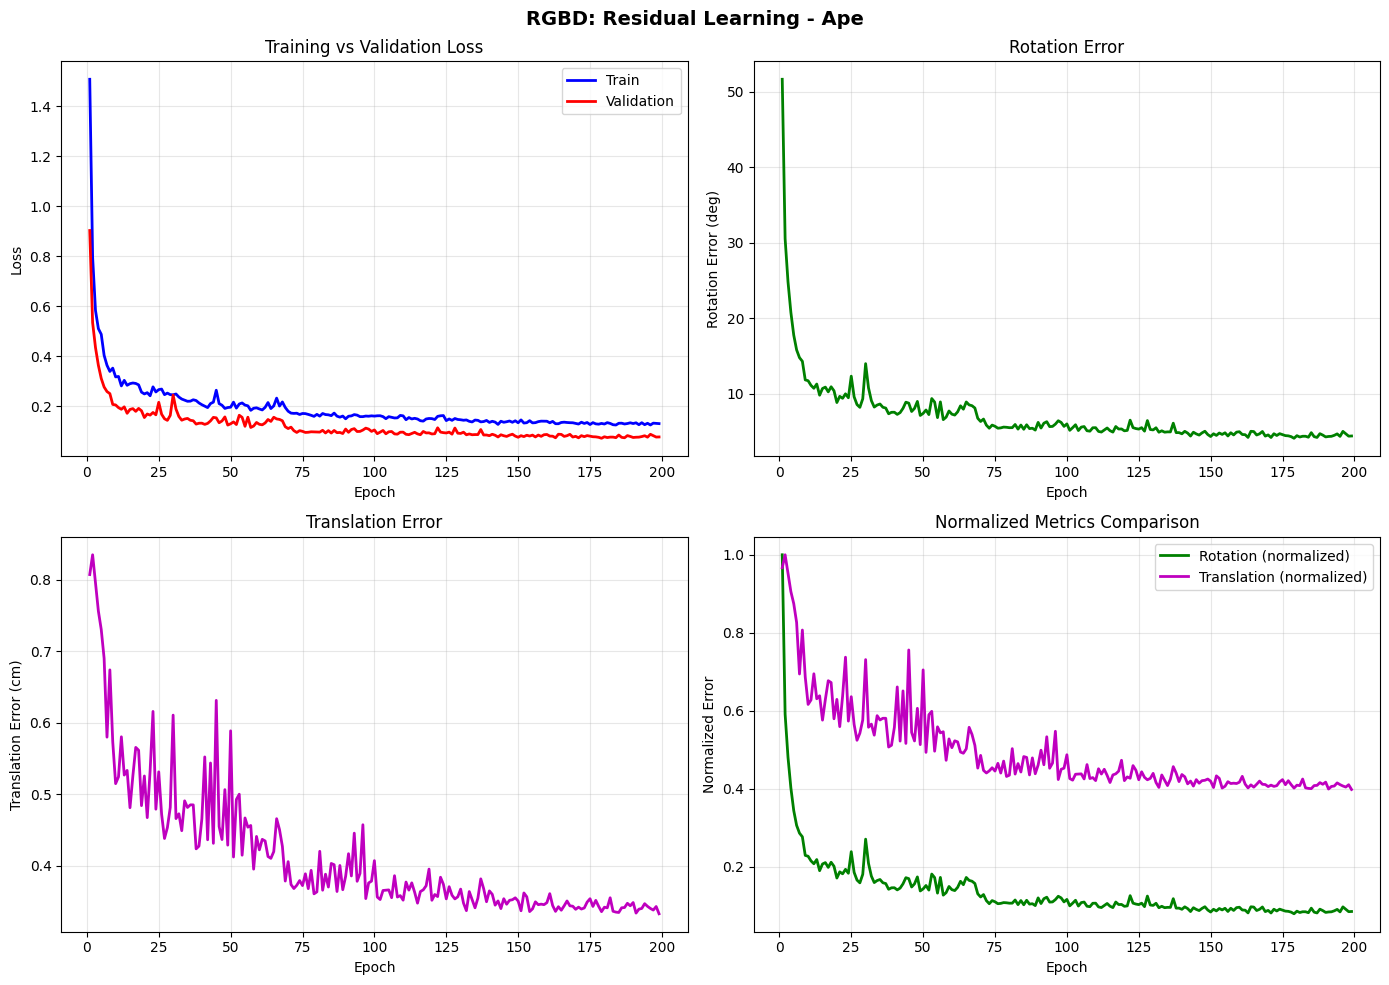

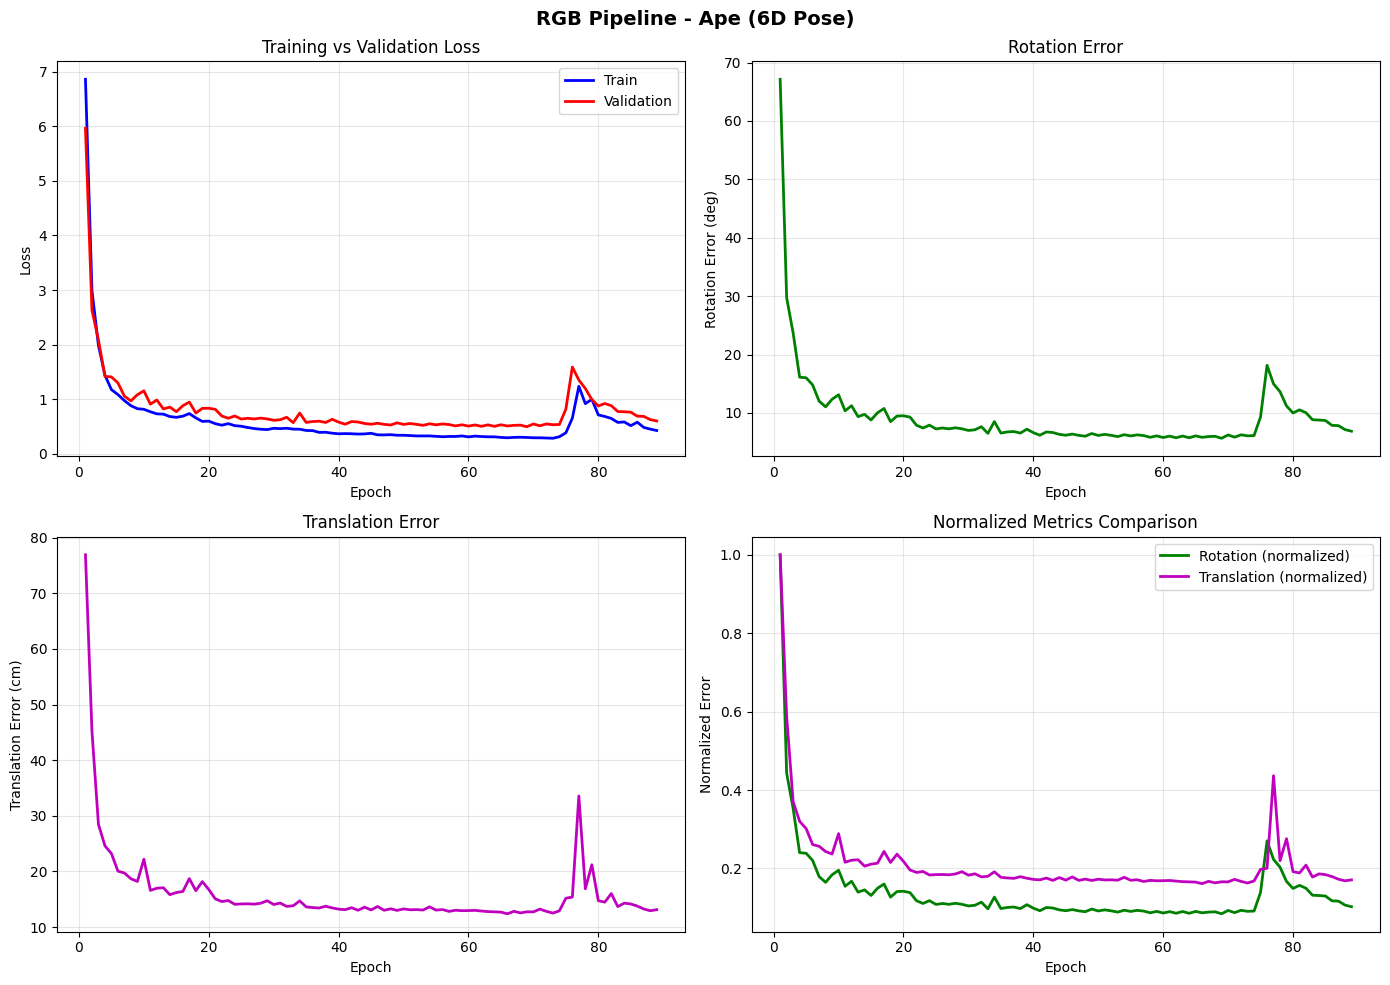

In [3]:
def plot_training_curves(history, title='Training Curves'):
    """
    Plot training and validation curves.
    
    Args:
        history: Normalized history dict
        title: Plot title
    """
    if history is None:
        print("Warning: No history to plot")
        return
    
    train_loss = history.get('train_loss', [])
    val_loss = history.get('val_loss', [])
    rot_err = history.get('rot_err', [])
    # trans_err = history.get('trans_err', [0] * len(val_loss))
    trans_err = history.get('trans_err', [])
    

    if not train_loss:
        print("Warning: No training data found in history")
        return
    
    # Determine layout based on whether we have translation data
    has_trans = trans_err and any(e > 0 for e in trans_err)
    n_cols = 2
    n_rows = 2 if has_trans else 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    epochs = range(1, len(train_loss) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, train_loss, 'b-', label='Train', linewidth=2)
    axes[0, 0].plot(epochs, val_loss, 'r-', label='Validation', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training vs Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Rotation Error
    axes[0, 1].plot(epochs, rot_err, 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Rotation Error (deg)')
    axes[0, 1].set_title('Rotation Error')
    axes[0, 1].grid(True, alpha=0.3)
    
    if has_trans:
        # Translation Error
        axes[1, 0].plot(epochs, trans_err, 'm-', linewidth=2)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Translation Error (cm)')
        axes[1, 0].set_title('Translation Error')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Combined metrics (normalized)
        max_rot = max(rot_err) if rot_err and max(rot_err) > 0 else 1
        max_trans = max(trans_err) if trans_err and max(trans_err) > 0 else 1
        rot_norm = np.array(rot_err) / max_rot
        trans_norm = np.array(trans_err) / max_trans
        
        axes[1, 1].plot(epochs, rot_norm, 'g-', label='Rotation (normalized)', linewidth=2)
        axes[1, 1].plot(epochs, trans_norm, 'm-', label='Translation (normalized)', linewidth=2)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Normalized Error')
        axes[1, 1].set_title('Normalized Metrics Comparison')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()


# Plot RGBD history
if history_rgbd:
    plot_training_curves(history_rgbd, 'RGBD: Residual Learning - Ape')

# Plot RGB history (now with translation)
if history_rgb:
    plot_training_curves(history_rgb, 'RGB Pipeline - Ape (6D Pose)')

## 3. Compare Multiple Models

Comparing RGBD Models:


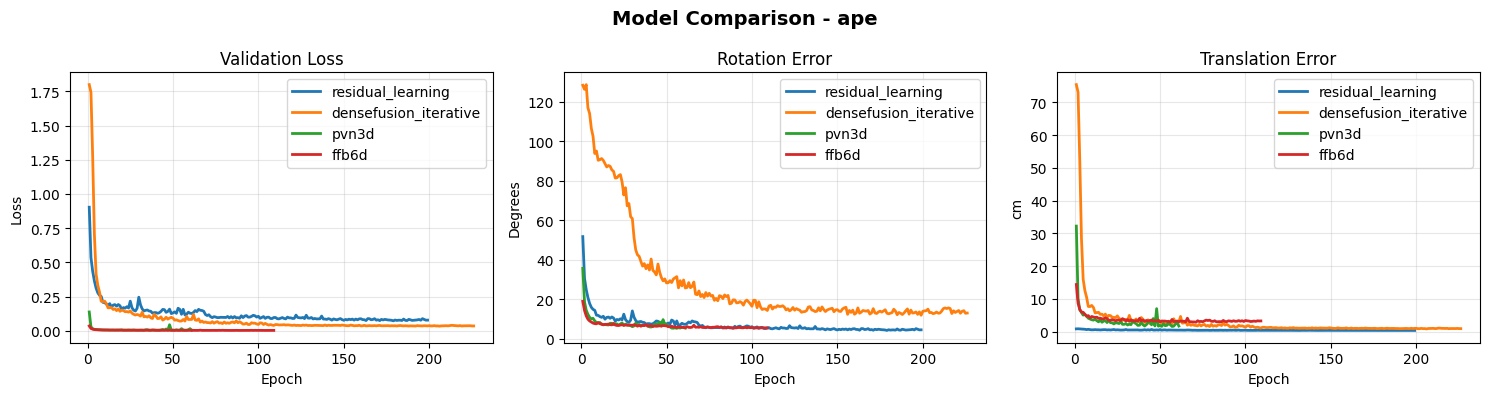


Comparing RGB vs RGBD:


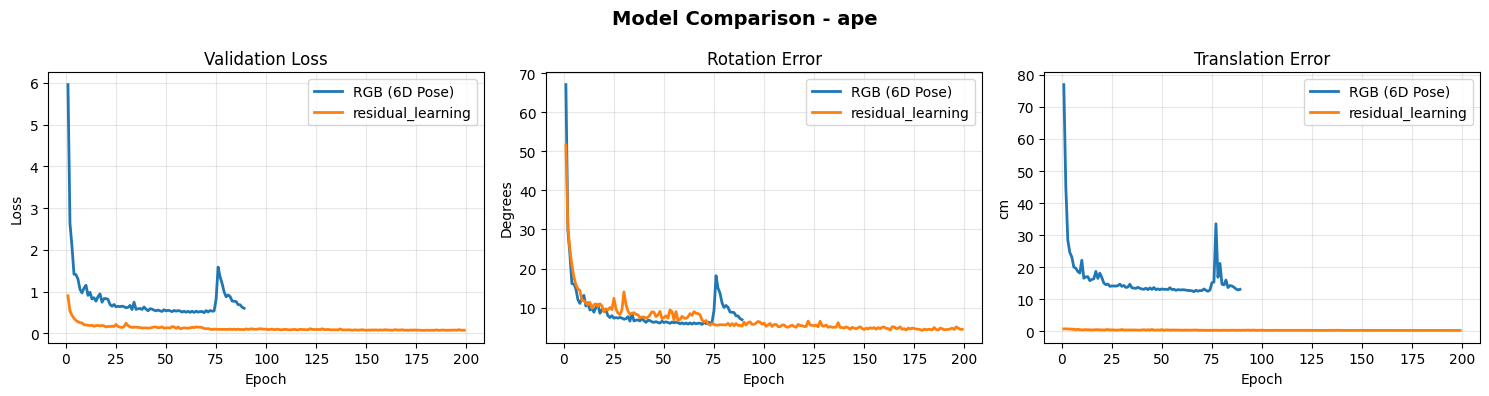

In [4]:
def compare_models(model_configs, object_name):
    """
    Compare training curves across multiple models.
    
    Args:
        model_configs: List of tuples (model_name, pipeline_type)
            e.g., [('rgb', 'rgb'), ('residual_learning', 'rgbd'), ...]
        object_name: Object name (e.g., 'ape')
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    has_data = False
    for model_name, pipeline_type in model_configs:
        history = load_history(model_name, object_name, pipeline_type)
        if history is None:
            continue
        
        has_data = True
        epochs = range(1, len(history['val_loss']) + 1)
        
        label = f"{model_name}"
        if pipeline_type == 'rgb':
            label = "RGB (6D Pose)"
        
        axes[0].plot(epochs, history['val_loss'], label=label, linewidth=2)
        axes[1].plot(epochs, history['rot_err'], label=label, linewidth=2)
        
        # Plot translation error (now available for both RGB and RGBD)
        if history['trans_err'] and any(e > 0 for e in history['trans_err']):
            axes[2].plot(epochs, history['trans_err'], label=label, linewidth=2)
    
    if not has_data:
        print("Warning: No training history found. Train models first.")
        plt.close(fig)
        return
    
    axes[0].set_title('Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Rotation Error')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Degrees')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].set_title('Translation Error')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('cm')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    fig.suptitle(f'Model Comparison - {object_name}', fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()


# Compare all RGBD models
print("Comparing RGBD Models:")
rgbd_models = [
    ('residual_learning', 'rgbd'),
    ('densefusion_iterative', 'rgbd'),
    ('pvn3d', 'rgbd'),
    ('ffb6d', 'rgbd')
]

compare_models(rgbd_models, 'ape')

# Compare RGB vs RGBD (now both predict full 6D pose)
print("\nComparing RGB vs RGBD:")
all_models = [
    ('rgb', 'rgb'),
    ('residual_learning', 'rgbd'),
]
compare_models(all_models, 'ape')


Complete Training Results
     Object              Pipeline Type Best Loss Rot Error (deg) Trans Error (cm)  Epochs
        ape         RGB (6D Pose)  RGB    0.4974            5.66            12.76      89
        ape     residual_learning RGBD    0.0724            4.13             0.34     199
        ape densefusion_iterative RGBD    0.0332           12.63             0.80     226
        ape                 pvn3d RGBD    0.0035            5.86             1.69      61
        ape                 ffb6d RGBD    0.0022            5.38             3.02     109
  benchvise         RGB (6D Pose)  RGB    0.6468            7.35            15.91      69
  benchvise     residual_learning RGBD    0.0778            4.41             0.59     188
  benchvise densefusion_iterative RGBD    0.0809           15.09             2.78     133
  benchvise                 pvn3d RGBD    0.0134            6.81             2.44      51
  benchvise                 ffb6d RGBD    0.0027            4.98         

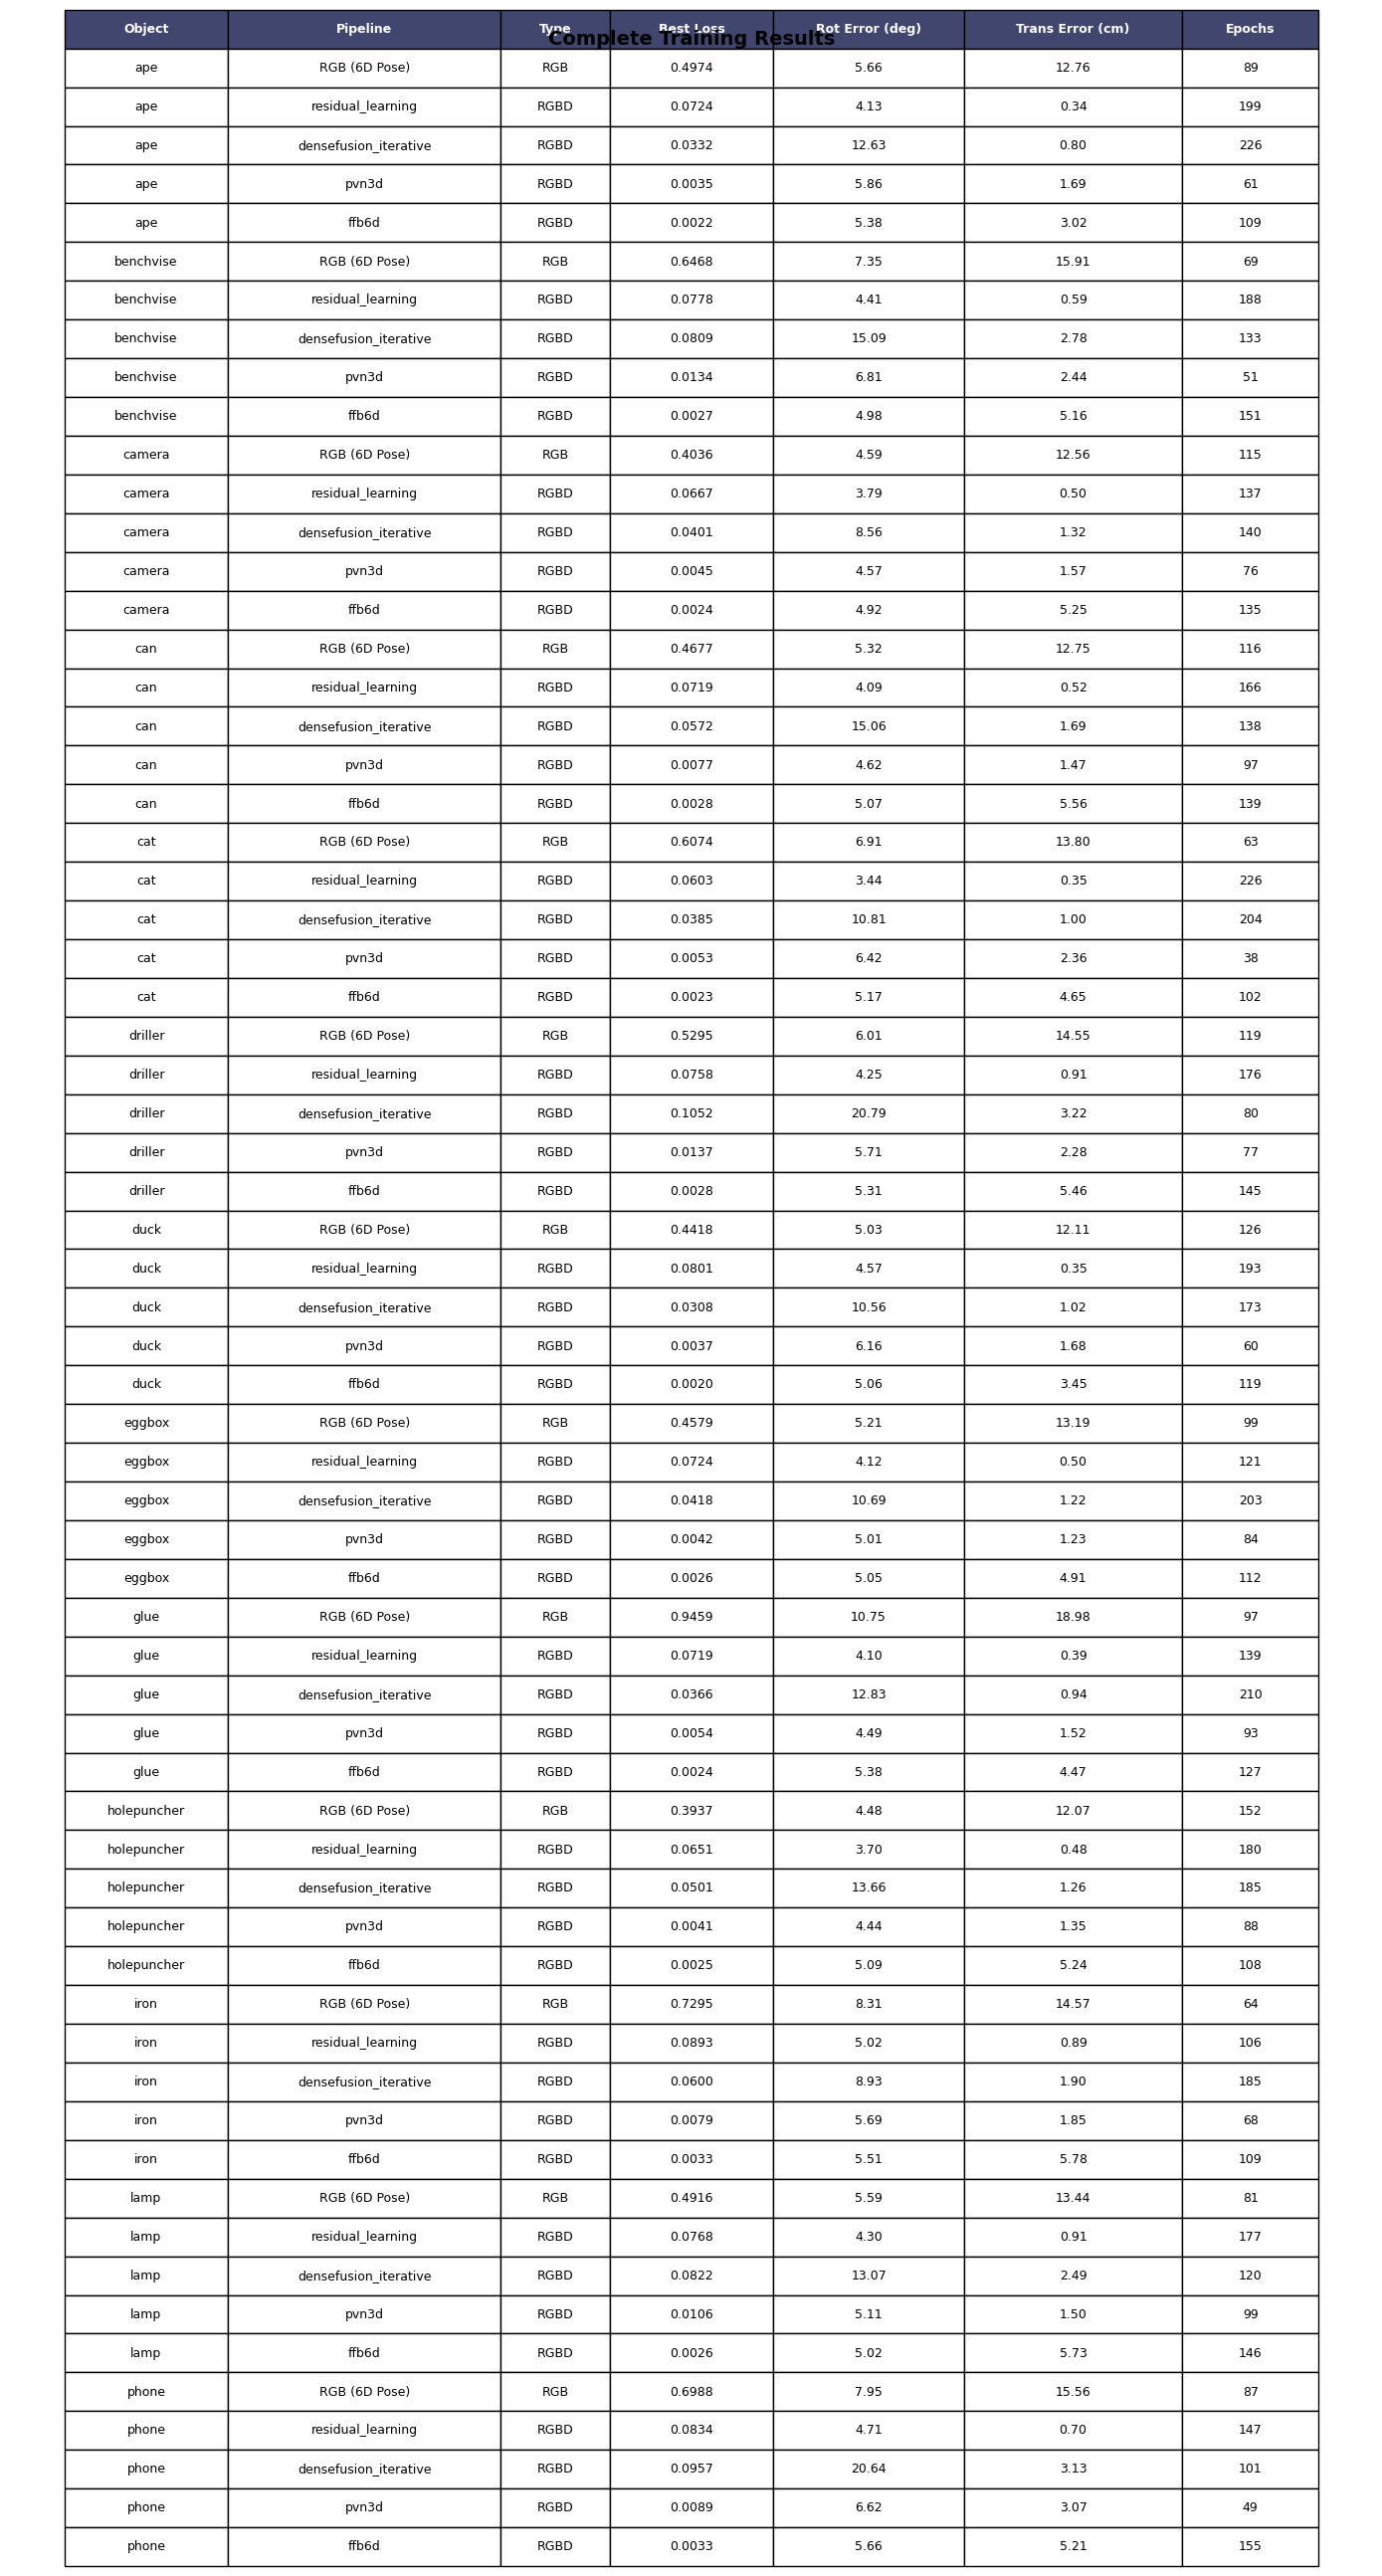

In [5]:
import pandas as pd

def create_results_table(objects, pipelines):
    """
    Create a comprehensive results table for all objects and pipelines.
    
    Args:
        objects: List of object names
        pipelines: List of tuples (model_name, pipeline_type)
    
    Returns:
        DataFrame with results
    """
    results = []
    
    for obj in objects:
        for model_name, pipeline_type in pipelines:
            history = load_history(model_name, obj, pipeline_type)
            if history is None:
                continue
            
            val_loss = history['val_loss']
            rot_err = history['rot_err']
            trans_err = history['trans_err']
            
            best_epoch = np.argmin(val_loss)
            best_loss = val_loss[best_epoch]
            best_rot_err = rot_err[best_epoch] if rot_err else None
            best_trans_err = trans_err[best_epoch] if trans_err and any(e > 0 for e in trans_err) else None
            
            # Display name
            display_name = model_name if pipeline_type == 'rgbd' else 'RGB (6D Pose)'
            
            results.append({
                'Object': obj,
                'Pipeline': display_name,
                'Type': pipeline_type.upper(),
                'Best Loss': f"{best_loss:.4f}",
                'Rot Error (deg)': f"{best_rot_err:.2f}" if best_rot_err else 'N/A',
                'Trans Error (cm)': f"{best_trans_err:.2f}" if best_trans_err else 'N/A',
                'Epochs': len(val_loss)
            })
    
    if not results:
        print("Warning: No results found. Train models first.")
        return None
    
    return pd.DataFrame(results)


def plot_results_table(df, title='Training Results Summary'):
    """Display results table with formatting."""
    if df is None:
        return
    
    print(f"\n{title}")
    print("=" * 100)
    print(df.to_string(index=False))
    print("=" * 100)
    
    # Visual table
    fig, ax = plt.subplots(figsize=(14, max(4, len(df) * 0.4)))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center',
        colWidths=[0.12, 0.2, 0.08, 0.12, 0.14, 0.16, 0.1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header
    for i in range(len(df.columns)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()


# Create comprehensive results table
all_objects = ['ape', 'benchvise', 'camera', 'can', 'cat', 'driller', 
               'duck', 'eggbox', 'glue', 'holepuncher', 'iron', 'lamp', 'phone']

all_pipelines = [
    ('rgb', 'rgb'),  # RGB now predicts full 6D pose
    ('residual_learning', 'rgbd'),
    ('densefusion_iterative', 'rgbd'),
    ('pvn3d', 'rgbd'),
    ('ffb6d', 'rgbd')
]

results_df = create_results_table(all_objects, all_pipelines)
if results_df is not None:
    plot_results_table(results_df, 'Complete Training Results')

## 4. Model Inference Demo

In [6]:
def demo_rgb_inference(object_name='ape'):
    """Demonstrate RGB model inference with the new pipeline."""
    from rgb_pipeline.model import RGBPoseEstimator
    from rgb_pipeline.config import ConfigRGB
    
    cfg = ConfigRGB()
    
    print(f"RGB Model Inference Demo ({object_name})")
    print("=" * 60)
    print("The RGB pipeline now predicts BOTH rotation AND translation.")
    print()
    
    # Create model
    model = RGBPoseEstimator(backbone=cfg.BACKBONE, pretrained=False)
    model.eval()
    
    # Create dummy inputs
    B = 2
    rgb = torch.randn(B, 3, cfg.INPUT_SIZE[0], cfg.INPUT_SIZE[1])
    pinhole_translation = torch.randn(B, 3) * 0.5  # Simulated pinhole estimate
    
    print(f"Input shapes:")
    print(f"  RGB crop:              {rgb.shape}")
    print(f"  Pinhole translation:   {pinhole_translation.shape}")
    
    with torch.no_grad():
        pred_rotation, pred_translation = model(rgb, pinhole_translation)
    
    print(f"\nOutput shapes:")
    print(f"  Rotation (quaternion): {pred_rotation.shape}")
    print(f"  Translation:           {pred_translation.shape}")
    
    print(f"\nSample output (batch 0):")
    print(f"  Rotation (w,x,y,z):    {pred_rotation[0].numpy()}")
    print(f"  Translation (x,y,z):   {pred_translation[0].numpy()} meters")
    
    print(f"\nModel parameters: {model.get_num_parameters():,}")
    
    return pred_rotation, pred_translation


def demo_rgbd_inference(model_name='residual_learning', num_points=256):
    """Demonstrate RGBD model inference."""
    from rgbd_pipelines import create_model
    
    print(f"\nRGBD Model Inference Demo ({model_name})")
    print("=" * 60)
    
    # Create model
    model_kwargs = {'num_points': num_points, 'num_obj': 13}
    if 'iterative' in model_name:
        model_kwargs['num_iter'] = 2
    if model_name in ['pvn3d', 'ffb6d']:
        model_kwargs['num_kp'] = 8
    
    model = create_model(model_name, **model_kwargs)
    model.eval()
    
    # Create dummy inputs
    B = 2
    rgb = torch.randn(B, 3, 128, 128)
    points = torch.randn(B, num_points, 3) * 0.1
    choose = torch.randint(0, 128*128, (B, num_points))
    obj_idx = torch.zeros(B, dtype=torch.long)
    
    print(f"Input shapes:")
    print(f"  RGB:          {rgb.shape}")
    print(f"  Points:       {points.shape}")
    print(f"  Choose:       {choose.shape}")
    print(f"  Object Index: {obj_idx.shape}")
    
    with torch.no_grad():
        output = model(rgb, points, choose, obj_idx)
    
    print(f"\nOutput shapes:")
    print(f"  Rotation:    {output['rotation'].shape}")
    print(f"  Translation: {output['translation'].shape}")
    
    print(f"\nSample rotation matrix (batch 0):")
    print(output['rotation'][0])
    
    print(f"\nSample translation (batch 0):")
    print(output['translation'][0])
    
    params = sum(p.numel() for p in model.parameters())
    print(f"\nModel parameters: {params:,}")
    
    return output


# Run demos
demo_rgb_inference()
demo_rgbd_inference('residual_learning')

RGB Model Inference Demo (ape)
The RGB pipeline now predicts BOTH rotation AND translation.

Input shapes:
  RGB crop:              torch.Size([2, 3, 224, 224])
  Pinhole translation:   torch.Size([2, 3])

Output shapes:
  Rotation (quaternion): torch.Size([2, 4])
  Translation:           torch.Size([2, 3])

Sample output (batch 0):
  Rotation (w,x,y,z):    [-0.8407427   0.02267958  0.12092385  0.52727103]
  Translation (x,y,z):   [ 6.2748604 -1.428335  -1.0645576] meters

Model parameters: 24,858,759

RGBD Model Inference Demo (residual_learning)
Input shapes:
  RGB:          torch.Size([2, 3, 128, 128])
  Points:       torch.Size([2, 256, 3])
  Choose:       torch.Size([2, 256])
  Object Index: torch.Size([2])

Output shapes:
  Rotation:    torch.Size([2, 3, 3])
  Translation: torch.Size([2, 3])

Sample rotation matrix (batch 0):
tensor([[-0.4420,  0.2190, -0.8699],
        [-0.8220,  0.2893,  0.4905],
        [ 0.3591,  0.9318,  0.0521]])

Sample translation (batch 0):
tensor([ 0.00

{'rotation': tensor([[[-0.4420,  0.2190, -0.8699],
          [-0.8220,  0.2893,  0.4905],
          [ 0.3591,  0.9318,  0.0521]],
 
         [[-0.4407,  0.2171, -0.8710],
          [-0.8261,  0.2816,  0.4882],
          [ 0.3513,  0.9346,  0.0552]]]),
 'translation': tensor([[ 0.0024,  0.0071, -0.0087],
         [ 0.0019,  0.0010, -0.0022]]),
 'quaternion': tensor([[-0.2327,  0.6479,  0.5488, -0.4742],
         [-0.2358,  0.6456,  0.5510, -0.4733]]),
 'delta_translation': tensor([[ 0.0005, -0.0002, -0.0005],
         [ 0.0006, -0.0002, -0.0006]]),
 'T_geo': tensor([[ 0.0018,  0.0073, -0.0081],
         [ 0.0013,  0.0012, -0.0016]])}

## 5. List Available Models

In [7]:
from rgbd_pipelines import list_models, create_model
from rgb_pipeline.model import RGBPoseEstimator
from rgb_pipeline.config import ConfigRGB

print("Available Models")
print("=" * 60)

# RGB Model
cfg = ConfigRGB()
rgb_model = RGBPoseEstimator(backbone=cfg.BACKBONE, pretrained=False)
rgb_params = rgb_model.get_num_parameters()
print(f"\nRGB Pipeline (predicts 6D pose):")
print(f"   {'RGB (ResNet50)':<25} {rgb_params:>12,} parameters")

# RGBD Models
print(f"\nRGBD Pipelines:")
for model_name in list_models():
    model_kwargs = {'num_points': 256, 'num_obj': 13}
    if 'iterative' in model_name:
        model_kwargs['num_iter'] = 2
    if model_name in ['pvn3d', 'ffb6d']:
        model_kwargs['num_kp'] = 8
    
    model = create_model(model_name, **model_kwargs)
    params = sum(p.numel() for p in model.parameters())
    print(f"   {model_name:<25} {params:>12,} parameters")

Available Models

RGB Pipeline (predicts 6D pose):
   RGB (ResNet50)              24,858,759 parameters

RGBD Pipelines:
   residual_learning           12,209,095 parameters
   densefusion_iterative       15,367,043 parameters
   pvn3d                       22,438,381 parameters
   ffb6d                       24,616,877 parameters
